In [107]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import rasterio
import rasterio.features
from rasterio.enums import Resampling
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import os
import osmnx as ox
from skimage.feature import graycomatrix
from skimage.util import view_as_windows
import dask.array as da
from dask.diagnostics import ProgressBar
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import joblib
from joblib import load

### Открываем границы Бангалора и домики, обрезанные по маске Бангалора, здания выгружены с [microsoft](https://github.com/microsoft/GlobalMLBuildingFootprints/tree/main). По Индии там данные за конец 2023 года.

In [124]:
bangalore = gpd.read_file('bangalore_boundary.gpkg')
bangalore_builds_clipped = gpd.read_file('data/bangalore_builds_clipped.geojson')
bangalore_wards = gpd.read_file('Границы/bangalore_wards.geojson')
bangalore_zones = bangalore_wards.dissolve(by='Zone', as_index=False)
bangalore_divisions = bangalore_wards.dissolve(by='Division', as_index=False)

In [17]:
len(bangalore_builds_clipped)

597584

### Делаем датасет с индексами и тематическими продуктами дистанционного зондирования, рассчитанные на каждый тайл 250 на 250 м
- NDVI
- NDBI
- GLCM
- IBI
- NightLights

In [10]:
# ----------  ПАРАМЕТРЫ  ----------
tif_path   = 'снимки/cropped/Bengaluru_Sentinel-2_cr.tif'
red_idx    = 3
green_idx  = 2
nir_idx    = 4
swir_idx   = 5
eps        = np.finfo('float32').eps

with rasterio.open(tif_path) as src:
    red   = src.read(red_idx,  out_dtype='float32', masked=True).filled(np.nan)
    green = src.read(green_idx,out_dtype='float32', masked=True).filled(np.nan)
    nir   = src.read(nir_idx,  out_dtype='float32', masked=True).filled(np.nan)
    swir  = src.read(swir_idx, out_dtype='float32', masked=True).filled(np.nan)
    profile = src.profile

# ----------  СПЕКТРАЛЬНЫЕ ИНДЕКСЫ ndbi  = (swir - nir)  / (swir + nir  + eps) ---------
ndvi  = (nir  - red)  / (nir  + red  + eps)
mndwi = (green - swir)/(green + swir + eps)

ibi_num = ndbi - (ndvi + mndwi)/2
ibi_den = ndbi + (ndvi + mndwi)/2 + eps
ibi = ibi_num / ibi_den
ibi = np.clip(ibi, -1, 1)


# ----------  СОХРАНЕНИЕ  ----------
def save_tif(arr, out_name):
    profile_upd = profile.copy()
    profile_upd.update(count=1, dtype='float32', nodata=np.nan)
    with rasterio.open(out_name, 'w', **profile_upd) as dst:
        dst.write(arr.astype('float32'), 1)

save_tif(ibi,'снимки/cropped/Bengaluru_IBI.tif')

In [13]:
# ---------------------------------------------------
# ПАРАМЕТРЫ
# ---------------------------------------------------
tif_path = "снимки/cropped/Bengaluru_Sentinel-2_cr.tif"
nir_idx  = 4
win      = 7       # размер окна GLCM (должен быть нечетным)
levels   = 16      # число уровней квантования (например, 16)
eps      = 1e-12

pad = win // 2

chunk_size = (2048, 2048)

with rasterio.open(tif_path) as src:
    nir_full = src.read(nir_idx, out_dtype="float32", masked=True).filled(np.nan)
    profile  = src.profile

da_nir = da.from_array(nir_full, chunks=chunk_size)

nir_min = da_nir.min().compute()
nir_max = da_nir.max().compute()


da_q = ((da_nir - nir_min) / (nir_max - nir_min + eps) * (levels - 1))\
        .map_blocks(lambda x: np.floor(x).astype(np.uint8),
                    dtype=np.uint8)

def glcm_entropy_block(block: np.ndarray) -> np.ndarray:
    rows_full, cols_full = block.shape
    rows_out = rows_full - 2 * pad
    cols_out = cols_full - 2 * pad

    out = np.empty((rows_out, cols_out), dtype=np.float32)

    for i in range(pad, rows_full - pad):
        for j in range(pad, cols_full - pad):
            w = block[i - pad : i + pad + 1, j - pad : j + pad + 1]

            G = np.zeros((levels, levels), dtype=np.float32)
            for r in range(win):
                for c in range(win - 1):
                    p = int(w[r, c])
                    q = int(w[r, c + 1])
                    G[p, q] += 1.0
                    G[q, p] += 1.0

            total = G.sum()
            if total > 0:
                G /= total
                h = 0.0
                nz = G > 0
                h = -np.sum(G[nz] * np.log2(G[nz] + eps))
                out[i - pad, j - pad] = h
            else:
                out[i - pad, j - pad] = np.nan

    return out

da_entropy = da_q.map_overlap(
    glcm_entropy_block,
    depth=(pad, pad),
    boundary="reflect",
    dtype=np.float32
)


with ProgressBar():
    entropy_result = da_entropy.compute()

def save_tif(arr: np.ndarray, out_name: str, ref_profile: dict):
    prof = ref_profile.copy()
    prof.update(count=1, dtype="float32", nodata=np.nan)
    with rasterio.open(out_name, "w", **prof) as dst:
        dst.write(arr.astype("float32"), 1)

with rasterio.open(tif_path) as ref:
    save_tif(entropy_result, "снимки/cropped/Bengaluru_GLCM_entropy_dask.tif", ref.profile)


[########################################] | 100% Completed | 119m 55s


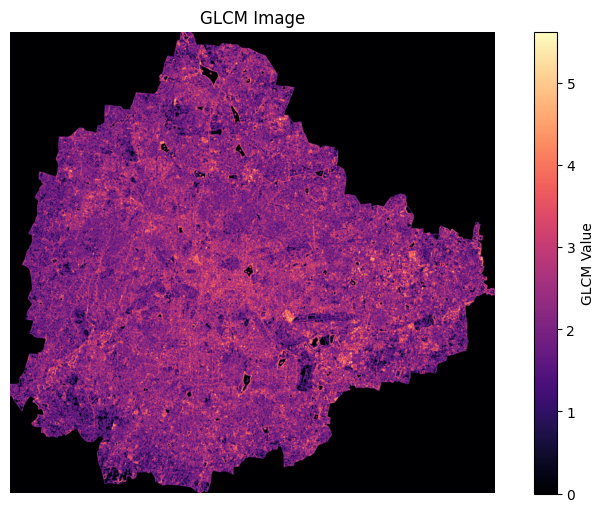

In [14]:
plt.figure(figsize=(10, 6))
plt.imshow(entropy_result, cmap='magma')
plt.colorbar(label='GLCM Value')
plt.title('GLCM Image')
plt.axis('off')
plt.show()

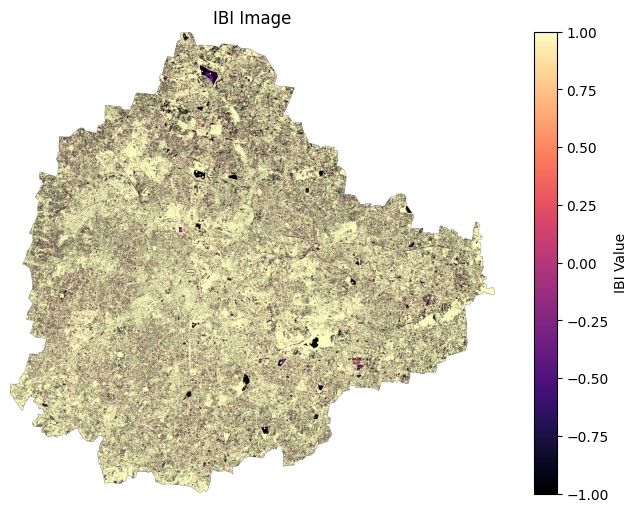

In [15]:
plt.figure(figsize=(10, 6))
plt.imshow(ibi, cmap='magma')
plt.colorbar(label='IBI Value')
plt.title('IBI Image')
plt.axis('off')
plt.show()

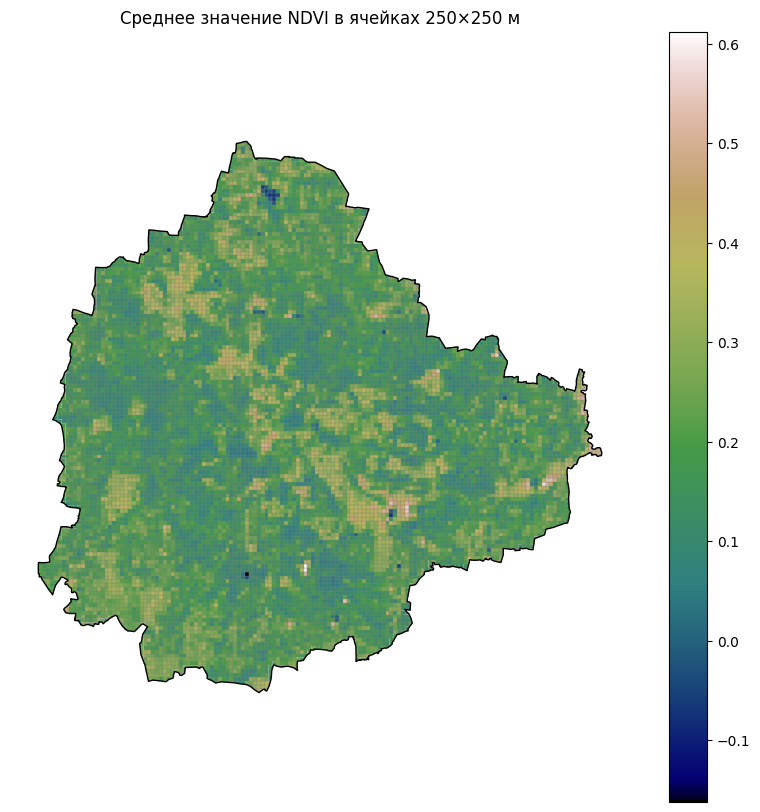

In [201]:
bangalore_metric = bangalore.to_crs(epsg=3857)

minx, miny, maxx, maxy = bangalore_metric.total_bounds
cell_size = 250
# ---------------------------------------------------
# Генерация сетки 250×250 м и обрезка по границам Бангалора
# ---------------------------------------------------
x_coords = np.arange(minx, maxx + cell_size, cell_size)
y_coords = np.arange(miny, maxy + cell_size, cell_size)

polygons = []
for x0 in x_coords[:-1]:
    for y0 in y_coords[:-1]:
        polygons.append(box(x0, y0, x0 + cell_size, y0 + cell_size))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=bangalore_metric.crs)
grid['tile_id'] = range(len(grid))

# Обрезаем сетку по области Бангалора
grid_clipped = gpd.overlay(grid, bangalore_metric, how='intersection')

# ---------------------------------------------------
# Открываем растровый файл Sentinel-2 и вычисляем NDVI, NDBI
# ---------------------------------------------------
raster_path = 'снимки/cropped/Bengaluru_Sentinel-2_cr.tif'
with rasterio.open(raster_path) as src:
    # Предполагается порядок: band1: Blue, band2: Green, band3: Red, band4: NIR, band5: SWIR
    blue = src.read(1).astype('float32')
    green = src.read(2).astype('float32')
    red = src.read(3).astype('float32')
    nir = src.read(4).astype('float32')
    swir = src.read(5).astype('float32')
    raster_transform = src.transform
    raster_crs = src.crs
    raster_height = src.height
    raster_width = src.width

# Вычисляем векторы индексов
ndvi_raster = np.where((nir + red) != 0, (nir - red) / (nir + red), np.nan)
ndbi_raster = np.where((swir + nir) != 0, (swir - nir) / (swir + nir), np.nan)
# ---------------------------------------------------
# Преобразуем сетку в CRS растров (если требуется)
# ---------------------------------------------------
grid_raster_crs = grid_clipped.to_crs(raster_crs)

# ---------------------------------------------------
# Для каждой ячейки считаем средние значения NDVI, NDBI
# ---------------------------------------------------
mean_ndvi = []
mean_ndbi = []

for geom in grid_raster_crs.geometry:
    mask = rasterio.features.geometry_mask(
        [geom],
        invert=True,
        transform=raster_transform,
        out_shape=(raster_height, raster_width)
    )
    # Извлекаем значения внутри ячейки
    vals_ndvi = ndvi_raster[mask]
    vals_ndbi = ndbi_raster[mask]
    
    # Вычисляем средние, учитывая NaN
    mean_ndvi.append(np.nanmean(vals_ndvi) if vals_ndvi.size > 0 else np.nan)
    mean_ndbi.append(np.nanmean(vals_ndbi) if vals_ndbi.size > 0 else np.nan)

# Добавляем колонки в grid_clipped (используем порядок индексов, совпадающий с grid_raster_crs)
grid_clipped['mean_ndvi'] = mean_ndvi
grid_clipped['mean_ndbi'] = mean_ndbi

# ---------------------------------------------------
# Открываем растровый файл GLCM-энтропии и вычисляем среднее GLCM по ячейкам
# ---------------------------------------------------
glcm_path = 'снимки/cropped/Bengaluru_GLCM_entropy_dask.tif'
with rasterio.open(glcm_path) as src_g:
    glcm_data = src_g.read(1).astype('float32')
    glcm_transform = src_g.transform
    glcm_crs = src_g.crs
    glcm_height = src_g.height
    glcm_width = src_g.width

# Если CRS растра GLCM отличается, приводим сетку:
if glcm_crs != raster_crs:
    grid_glcm_crs = grid_clipped.to_crs(glcm_crs)
else:
    grid_glcm_crs = grid_raster_crs  # уже в одном CRS

mean_glcm = []
for geom in grid_glcm_crs.geometry:
    mask = rasterio.features.geometry_mask(
        [geom],
        invert=True,
        transform=glcm_transform,
        out_shape=(glcm_height, glcm_width)
    )
    vals_glcm = glcm_data[mask]
    mean_glcm.append(np.nanmean(vals_glcm) if vals_glcm.size > 0 else np.nan)

grid_clipped['mean_glcm'] = mean_glcm

# ---------------------------------------------------
# Открываем растровый файл ночного освещения и вычисляем среднее
# ---------------------------------------------------
night_path = 'снимки/cropped/Bengaluru_NightLights_2024_2025_cr.tif'
with rasterio.open(night_path) as src_n:
    night_data = src_n.read(1).astype('float32')
    night_transform = src_n.transform
    night_crs = src_n.crs
    night_height = src_n.height
    night_width = src_n.width

# Приводим сетку, если CRS ночного освещения не совпадает
if night_crs != raster_crs:
    grid_night_crs = grid_clipped.to_crs(night_crs)
else:
    grid_night_crs = grid_raster_crs

mean_night = []
for geom in grid_night_crs.geometry:
    mask = rasterio.features.geometry_mask(
        [geom],
        invert=True,
        transform=night_transform,
        out_shape=(night_height, night_width)
    )
    vals_night = night_data[mask]
    mean_night.append(np.nanmean(vals_night) if vals_night.size > 0 else np.nan)

grid_clipped['mean_nightlights'] = mean_night

# ---------------------------------------------------
# Открываем растровый файл индекса IBI и вычисляем среднее
# ---------------------------------------------------
ibi_path = 'снимки/cropped/Bengaluru_IBI.tif'
with rasterio.open(ibi_path) as src_n:
    ibi_data = src_n.read(1).astype('float32')
    ibi_transform = src_n.transform
    ibi_crs = src_n.crs
    ibi_height = src_n.height
    ibi_width = src_n.width

# Приводим сетку, если CRS ночного освещения не совпадает
if ibi_crs != raster_crs:
    grid_ibi_crs = grid_clipped.to_crs(ibi_crs)
else:
    grid_ibi_crs = grid_raster_crs

mean_ibi = []
for geom in grid_ibi_crs.geometry:
    mask = rasterio.features.geometry_mask(
        [geom],
        invert=True,
        transform=ibi_transform,
        out_shape=(ibi_height, ibi_width)
    )
    vals_ibi = ibi_data[mask]
    mean_ibi.append(np.nanmean(vals_ibi) if vals_ibi.size > 0 else np.nan)

grid_clipped['mean_ibi'] = mean_ibi

fig, ax = plt.subplots(figsize=(10, 10))
grid_clipped.plot(
    column='mean_ndvi',
    cmap='gist_earth',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
bangalore_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Среднее значение NDVI в ячейках 250×250 м')
ax.axis('equal')
ax.axis('off')
plt.show()

In [53]:
len(grid_clipped['mean_nightlights'].isna())

12513

### Так как рамка очень неудасно попала на тематический продукт с ночным светом (у которого разрешение 500 на 500 м) там много пропусков, исправим это

In [54]:
sindex = grid_clipped.sindex

def get_neighbor_indices(idx, geometry, sindex, grid_clipped):
    # Найдём все индексы, чьи bounding box’ы пересекаются явно
    candidate_idx = list(sindex.intersection(geometry.bounds))
    candidate_idx = [i for i in candidate_idx if i != idx]
    
    # Оставим только тех, чьи полигоны действительно соприкасаются:
    neighbors = []
    for i in candidate_idx:
        # .touches() вернёт True, если геометрии лишь касаются (ребро или точка)
        # Можно заменить на .intersects(), если нужно брать и частичное наложение (но у сетки это почти то же самое).
        if grid_clipped.geometry.iloc[i].touches(geometry):
            neighbors.append(i)
    return neighbors

# Функция, которая одна итерация «заполняет» NaN значений средним по соседям:
def fill_once(grid_clipped):
    values = grid_clipped['mean_nightlights'].values
    geoms  = grid_clipped.geometry.values
    new_values = values.copy()
    
    for idx, val in enumerate(values):
        if np.isnan(val):
            neigh_idxs = get_neighbor_indices(idx, geoms[idx], sindex, grid_clipped)
            neigh_vals = [values[i] for i in neigh_idxs if not np.isnan(values[i])]
            if len(neigh_vals) > 0:
                new_values[idx] = np.mean(neigh_vals)
    return new_values

# Итеративно «затягиваем» пропуски до тех пор, пока что-то меняется или пока не останутся соседи:
prev_nans = grid_clipped['mean_nightlights'].isna().sum()
iteration = 0
while True:
    iteration += 1
    filled = fill_once(grid_clipped)
    grid_clipped['mean_nightlights'] = filled
    
    curr_nans = grid_clipped['mean_nightlights'].isna().sum()
    print(f"Итерация {iteration}: осталось NaN = {curr_nans}")
    
    # Если новых заполнений не произошло или NaN не изменились — выходим
    if curr_nans == 0 or curr_nans == prev_nans:
        break
    prev_nans = curr_nans


Итерация 1: осталось NaN = 178
Итерация 2: осталось NaN = 4
Итерация 3: осталось NaN = 2
Итерация 4: осталось NaN = 0


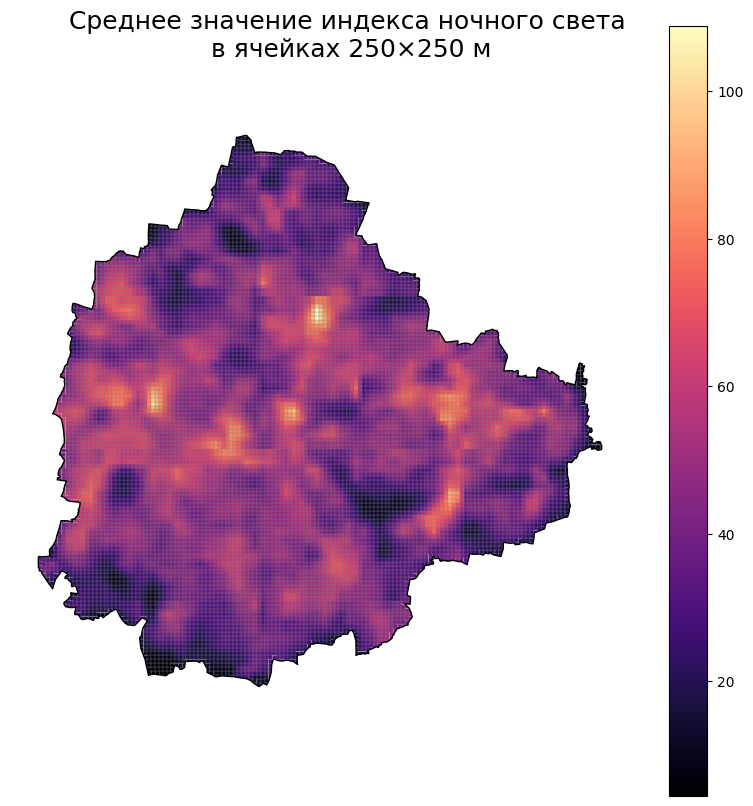

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_clipped.plot(
    column='mean_nightlights',
    cmap='magma',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
bangalore_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Среднее значение индекса ночного света \nв ячейках 250×250 м',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('off')
plt.show()

### Добавим домики

In [58]:
if bangalore_builds_clipped.crs != grid_clipped.crs:
    bangalore_builds_clipped = bangalore_builds_clipped.to_crs(grid_clipped.crs)

# Рассчитываем полную площадь зданий (в м²)
bangalore_builds_clipped["build_area_m2"] = bangalore_builds_clipped.geometry.area

# какие здания пересекают каждый тайл?
builds_with_tile = gpd.sjoin(
    bangalore_builds_clipped[["geometry", "build_area_m2"]],
    grid_clipped[["tile_id", "geometry"]],
    how="inner",
    predicate="intersects"
).drop(columns="index_right")

builds_stats = builds_with_tile.groupby("tile_id").agg(
    total_builds_count=("build_area_m2", "count"),
    median_build_area=("build_area_m2", "median"),
    count_small_builds=("build_area_m2", lambda x: np.sum(x <= 40))
).reset_index()

grid_clipped = grid_clipped.set_index("tile_id")
builds_stats = builds_stats.set_index("tile_id")

grid_clipped["total_builds_count"] = builds_stats["total_builds_count"].fillna(0).astype(int)
grid_clipped["median_build_area_m2"] = builds_stats["median_build_area"].fillna(0)
grid_clipped["count_small_builds"] = builds_stats["count_small_builds"].fillna(0).astype(int)

# Рассчитываем процент зданий < 40 м²
grid_clipped["pct_builds_less_40m2"] = np.where(
    grid_clipped["total_builds_count"] > 0,
    grid_clipped["count_small_builds"] / grid_clipped["total_builds_count"],
    0.0
)

# Рассчитываем процент площади тайла, занятой зданиями
intersections = gpd.overlay(
    grid_clipped.reset_index()[["tile_id", "geometry"]],
    bangalore_builds_clipped[["geometry"]],
    how="intersection"
)
intersections["intersection_area"] = intersections.geometry.area
area_per_tile = intersections.groupby("tile_id")["intersection_area"].sum().reset_index()

# Добавляем процент занятости тайла
tile_area = 250 * 250
area_per_tile = area_per_tile.set_index("tile_id")
grid_clipped["builds_area_m2"] = area_per_tile["intersection_area"].fillna(0)
grid_clipped["pct_tile_built_area"] = grid_clipped["builds_area_m2"] / tile_area

grid_clipped = grid_clipped.reset_index(drop=False)
grid_clipped.to_file("bangalore_aggregated_tiles_with_builds.geojson", driver="GeoJSON", encoding="utf-8")

grid_clipped.head()

,tile_id,geometry,mean_ndvi,mean_ndbi,mean_glcm,mean_nightlights,mean_ibi,total_builds_count,median_build_area_m2,count_small_builds,pct_builds_less_40m2,builds_area_m2,pct_tile_built_area
0,28,"POLYGON ((8623063.401 1447980.672, 8623063.401...",NaN,NaN,NaN,44.150002,NaN,1.0,2255.592614,0.0,0.000000,1.192176,0.000019
1,29,"POLYGON ((8623063.401 1448230.672, 8623063.401...",0.148580,0.105203,2.106030,44.150002,0.866179,1.0,2255.592614,0.0,0.000000,49.472318,0.000792
2,30,"POLYGON ((8623063.401 1448480.672, 8623063.401...",0.199211,0.075081,1.833542,39.255001,0.698017,23.0,106.993869,3.0,0.130435,3289.204587,0.052627
3,31,"POLYGON ((8623063.401 1448730.672, 8623063.401...",0.205048,0.079548,1.748581,34.360001,0.700168,18.0,120.588653,4.0,0.222222,2032.111635,0.032514
4,32,"POLYGON ((8623063.401 1448980.672, 8623063.401...",0.209201,0.087848,1.833414,34.360001,0.749085,NaN,NaN,NaN,0.000000,NaN,NaN


### Воспользуемся готовой моделью, которую мы уже сделали ранее на Мумбаи

In [90]:
rf_model = load("модель//best_slum_builds_model_rf300.pkl")
    
feature_cols = ['mean_ndvi', 'mean_ndbi', 'mean_ibi', 'mean_glcm',
       'mean_nightlights', 'total_builds_count','median_build_area_m2',
                'pct_builds_less_40m2','pct_tile_built_area']

grid_clipped = grid_clipped.fillna(0)
X_new = grid_clipped[feature_cols]
y_pred = rf_model.predict(X_new)
grid_clipped['slum_area_m2'] = y_pred
grid_clipped['slums'] = grid_clipped['slum_area_m2']/(250**2)>0.265

Изображение сохранено: Визуализация/Bengaluru_slums_area.png


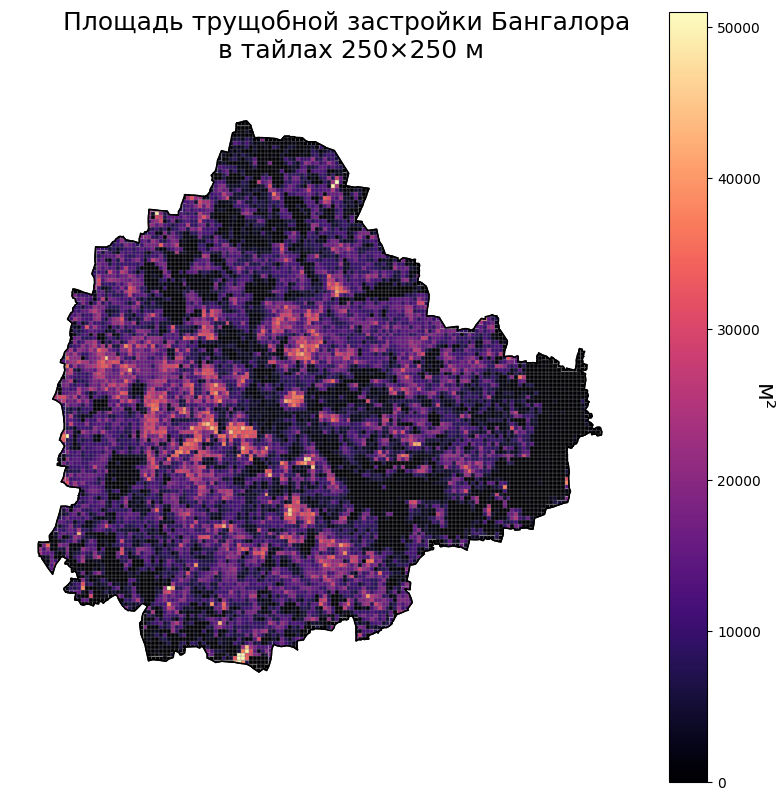

In [217]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_clipped.plot(
    column='slum_area_m2',
    cmap='magma',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
bangalore_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Площадь трущобной застройки Бангалора \nв тайлах 250×250 м',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.93, x =0.55)
bangalore_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
cbar = ax.get_figure().axes[-1]
cbar.set_ylabel('м²', rotation=270, labelpad=10, loc = 'center', fontdict = {'fontsize': 17})
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_slums_area.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

Изображение сохранено: Визуализация/Bengaluru_slums_yes-no.png


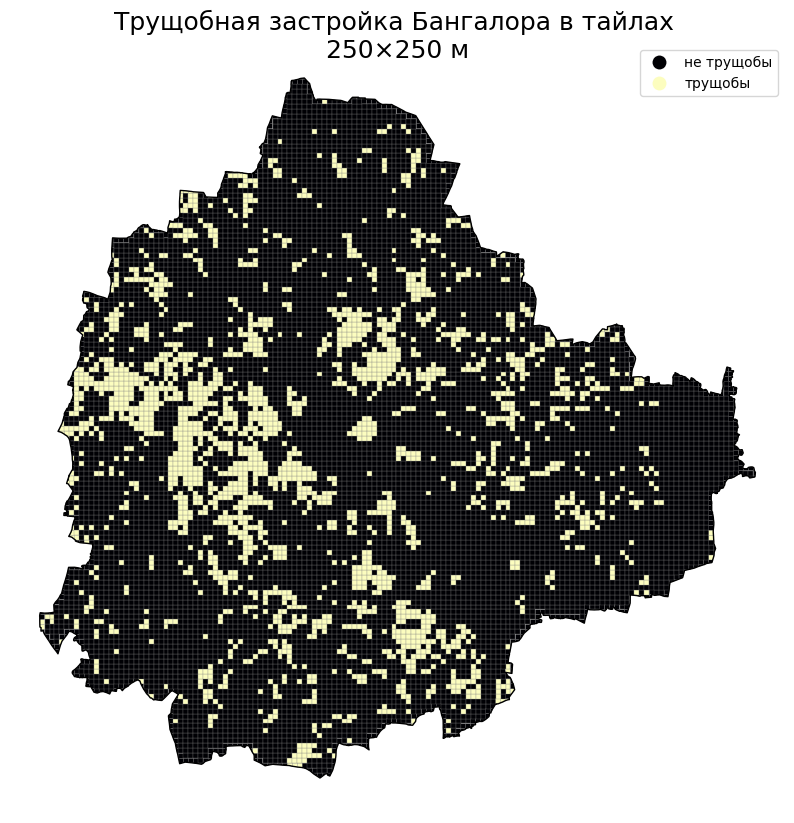

In [213]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_clipped.plot(
    column='slums',
    cmap='magma',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
bangalore_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Трущобная застройка Бангалора в тайлах \n250×250 м',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.97, x =0.5)
leg = ax.get_legend()
for txt in leg.get_texts():
    if txt.get_text() == 'False':
        txt.set_text('не трущобы')
    elif txt.get_text() == 'True':
        txt.set_text('трущобы')
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_slums_yes-no.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

Изображение сохранено: Визуализация/Bengaluru_buildings_area.png


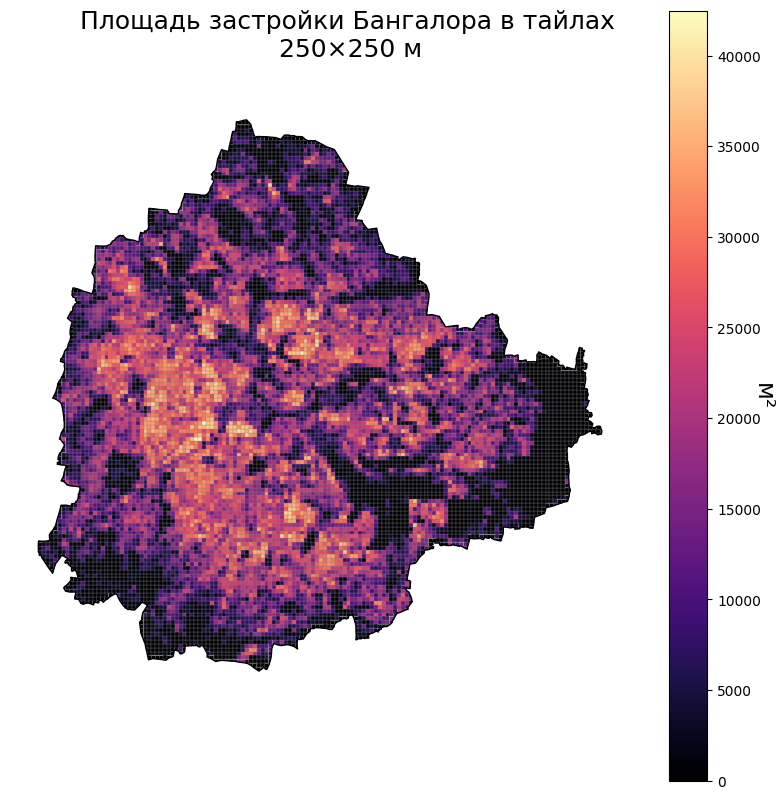

In [218]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_clipped.plot(
    column='builds_area_m2',
    cmap='magma',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
bangalore_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Площадь застройки Бангалора в тайлах \n250×250 м',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.93, x =0.55)
cbar = ax.get_figure().axes[-1]
cbar.set_ylabel('м²', rotation=270, labelpad=10, loc = 'center', fontdict = {'fontsize': 17})
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_buildings_area.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

### Выставим некоторые пороги по индесам, чтобы выделить застройку 
(но использовать потом мы это не будем)

(3441, 3611)
(3441, 3611)
(3429, 3599)
Изображение сохранено: Визуализация/Bengaluru_buildings_indexes.png


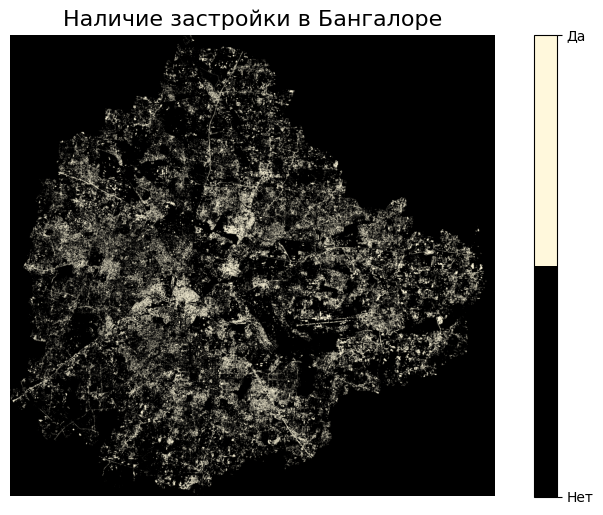

In [203]:
print(ndbi_raster.shape)
print(ndvi_raster.shape)
print(entropy_result.shape)

min_rows = min(ndbi_raster.shape[0], ndvi_raster.shape[0], entropy_result.shape[0])
min_cols = min(ndbi_raster.shape[1], ndvi_raster.shape[1], entropy_result.shape[1])

ndbi_raster_cropped = ndbi_raster[:min_rows, :min_cols]
ndvi_raster_cropped = ndvi_raster[:min_rows, :min_cols]
entropy_result_cropped = entropy_result[:min_rows, :min_cols]

data_filtered = (ndbi_raster_cropped > 0.05) & (ndvi_raster_cropped < 0.1) & (ndvi_raster_cropped > -0.05) & (entropy_result_cropped > 1)
cmap = ListedColormap(['black', '#FFF8DC'])

plt.figure(figsize=(10, 6))
plt.imshow(data_filtered, cmap=cmap)

cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['Нет', 'Да'])

plt.title('Наличие застройки в Бангалоре',
             {'fontsize': 16,'horizontalalignment': 'center'})
plt.axis('off')

output_image = "Визуализация/Bengaluru_buildings_indexes.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

### Административные зоны Бангалора

In [147]:
bangalore_zones = bangalore_zones.to_crs(grid_clipped.crs)
bangalore_zones['geometry'] = bangalore_zones['geometry'].buffer(0)
grid_clipped['geometry'] = grid_clipped['geometry'].buffer(0)

grid_with_zone = gpd.sjoin(
    grid_clipped[['builds_area_m2', 'slum_area_m2', 'geometry']],
    bangalore_zones[['Zone', 'geometry']],
    how='inner',
    predicate='within'
)

sum_agg = (
    grid_with_zone
    .groupby('Zone')[['builds_area_m2', 'slum_area_m2']]
    .sum()
    .reset_index()
)

bangalore_zones_aggregated = bangalore_zones.merge(
    sum_agg,
    on='Zone',
    how='left'
)

bangalore_zones_aggregated['area'] = bangalore_zones_aggregated.geometry.area
bangalore_zones_aggregated['builds/area'] = bangalore_zones_aggregated['builds_area_m2'] / bangalore_zones_aggregated['area']
bangalore_zones_aggregated['slums/area'] = bangalore_zones_aggregated['slum_area_m2'] / bangalore_zones_aggregated['area']
bangalore_zones_aggregated['slums/all_builds'] = bangalore_zones_aggregated['slum_area_m2'] / (bangalore_zones_aggregated['builds_area_m2'] + bangalore_zones_aggregated['slum_area_m2'])

bangalore_zones_aggregated.to_file("bangalore_zones_aggregated.geojson")
bangalore_zones_aggregated.to_file("bangalore_zones_aggregated.shp")

C:\Users\Mariia\AppData\Local\Temp\ipykernel_12336\1347821837.py:31: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bangalore_zones_aggregated.to_file("bangalore_zones_aggregated.shp")
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'styleMapHash' to 'styleMapHa'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'description' to 'descriptio'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke-opacity' to 'stroke-opa'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke-width' to 'stroke-wid'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: N

Изображение сохранено: Визуализация/Bengaluru_zones_slums.png


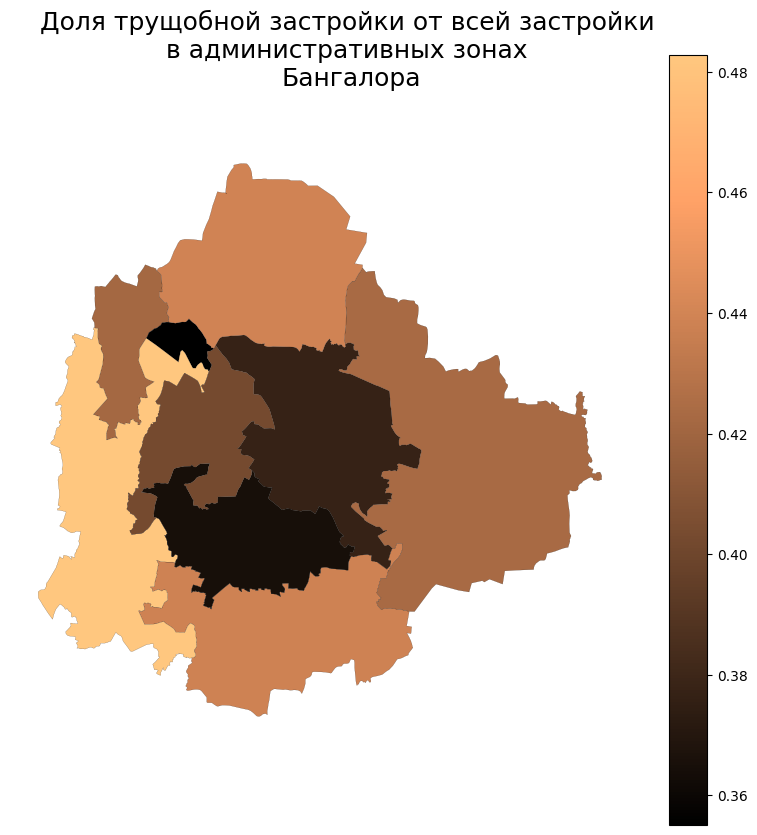

In [148]:
fig, ax = plt.subplots(figsize=(10, 10))
bangalore_zones_aggregated.plot(
    column='slums/all_builds',
    cmap='copper', #gist_yarg'
    legend=True,
    edgecolor='black',
    linewidth=0.1,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
# bangalore_divisions_aggregated.boundary.plot(ax=ax, edgecolor='grey', linewidth=0.1)
ax.set_title('Доля трущобной застройки от всей застройки \nв административных зонах \nБангалора',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_zones_slums.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

In [149]:
# Обрезаем красивую цветовую шкалу, чтобы сверху не было белого, выглядит как пробел в дыннх
base = plt.get_cmap('gist_heat')
trunc = LinearSegmentedColormap.from_list(
    'trunc_gist_heat',
    base(np.linspace(0, 0.9, 256))
)

Изображение сохранено: Визуализация/Bengaluru_zones_all_buildings.png


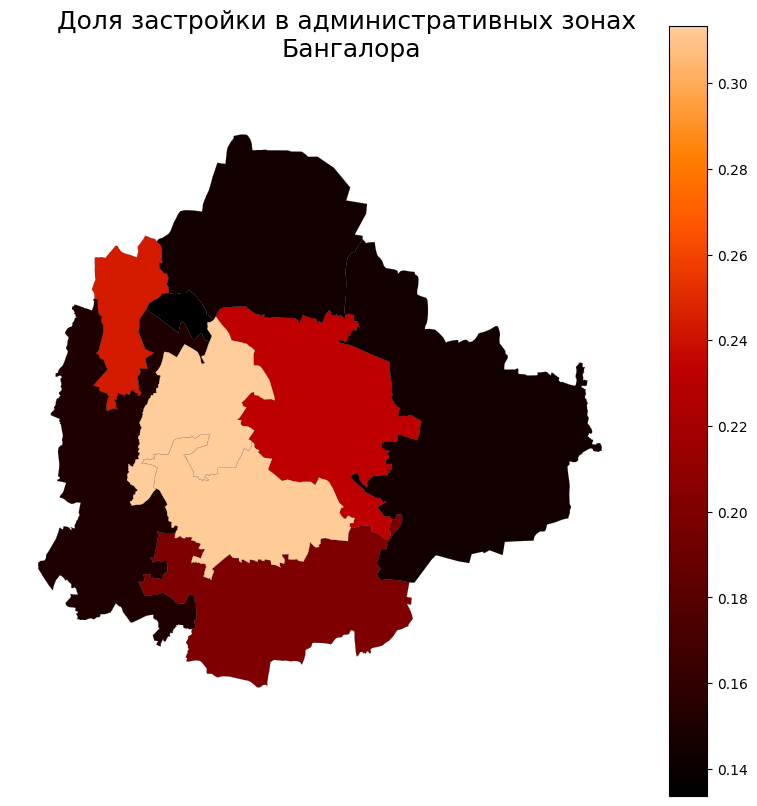

In [150]:
fig, ax = plt.subplots(figsize=(10, 10))
bangalore_zones_aggregated.plot(
    column='builds/area',
    cmap=trunc,
    legend=True,
    edgecolor='black',
    linewidth=0.1,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)

# bangalore_divisions_aggregated.boundary.plot(ax=ax, edgecolor='black', linewidth=0.1)
ax.set_title('Доля застройки в административных зонах \nБангалора',
             {'fontsize': 18,'horizontalalignment': 'center'}, loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_zones_all_buildings.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

Изображение сохранено: Визуализация/Bengaluru_zones_slums_15.png


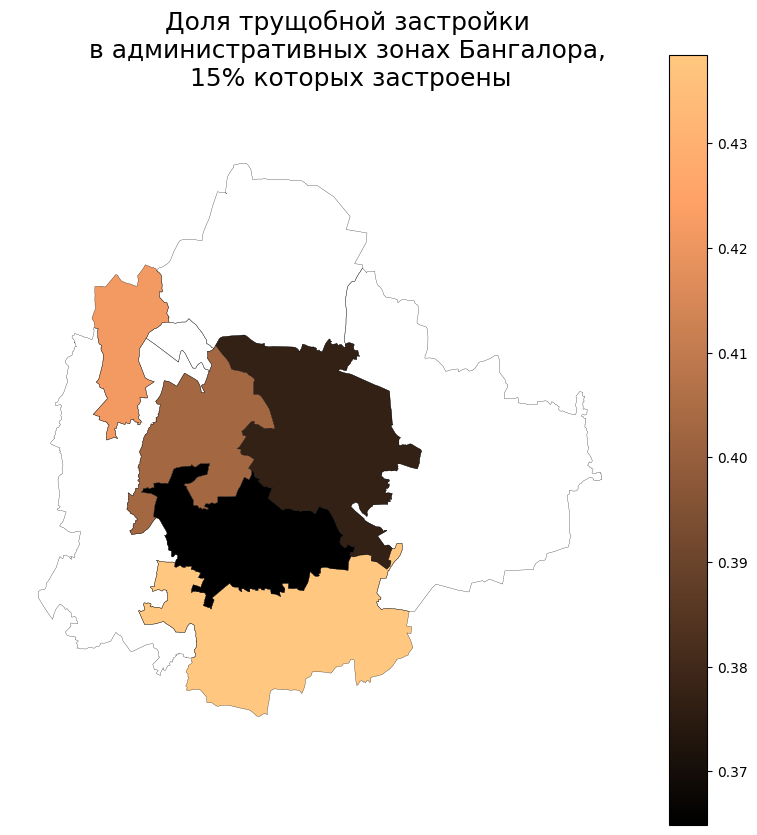

In [151]:
bangalore_zones_filtered = bangalore_zones_aggregated[bangalore_zones_aggregated['builds/area']>0.15]
fig, ax = plt.subplots(figsize=(10, 10))
bangalore_zones_filtered.plot(
    column='slums/all_builds',
    cmap='copper',
    legend=True,
    # edgecolor='grey',
    # linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
bangalore_zones_aggregated.boundary.plot(ax=ax, edgecolor='black', linewidth=0.2)
ax.set_title('Доля трущобной застройки \nв административных зонах Бангалора, \n15% которых застроены',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_zones_slums_15.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

### Административные округа Бангалора

In [152]:
bangalore_divisions = bangalore_divisions.to_crs(grid_clipped.crs)
grid_with_bangalore_divisions = gpd.sjoin(
    grid_clipped[['builds_area_m2', 'slum_area_m2', 'geometry']],
    bangalore_divisions[['Division', 'geometry']],
    how='inner',
    predicate='within'
)

sum_agg = (
    grid_with_bangalore_divisions
    .groupby('Division')[['builds_area_m2', 'slum_area_m2']]
    .sum()
    .reset_index()
)

bangalore_divisions_aggregated = bangalore_divisions.merge(
    sum_agg,
    on='Division',
    how='left'
)
bangalore_divisions_aggregated['area'] = bangalore_divisions_aggregated.geometry.area
bangalore_divisions_aggregated['builds/area'] = bangalore_divisions_aggregated['builds_area_m2'] / bangalore_divisions_aggregated['area']
bangalore_divisions_aggregated['slums/area'] = bangalore_divisions_aggregated['slum_area_m2'] / bangalore_divisions_aggregated['area']
bangalore_divisions_aggregated['slums/all_builds'] = bangalore_divisions_aggregated['slum_area_m2'] / (bangalore_divisions_aggregated['builds_area_m2'] + bangalore_divisions_aggregated['slum_area_m2'])

bangalore_divisions_aggregated.to_file("bangalore_divisions_aggregated.geojson", driver='GeoJSON')
bangalore_divisions_aggregated.to_file("bangalore_divisions_aggregated.shp")

C:\Users\Mariia\AppData\Local\Temp\ipykernel_12336\4065220051.py:27: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bangalore_divisions_aggregated.to_file("bangalore_divisions_aggregated.shp")
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'styleMapHash' to 'styleMapHa'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'description' to 'descriptio'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke-opacity' to 'stroke-opa'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke-width' to 'stroke-wid'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWa

Изображение сохранено: Визуализация/Bengaluru_divisions_slums.png


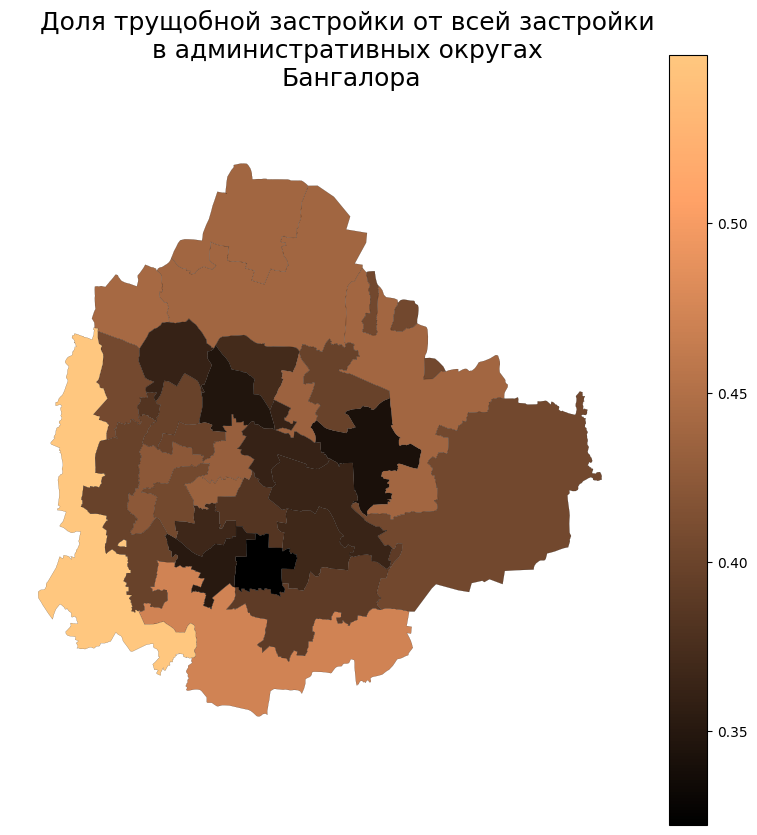

In [198]:
fig, ax = plt.subplots(figsize=(10, 10))
bangalore_divisions_aggregated.plot(
    column='slums/all_builds',
    cmap='copper', #gist_yarg'
    legend=True,
    edgecolor='black',
    linewidth=0.1,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
# bangalore_divisions_aggregated.boundary.plot(ax=ax, edgecolor='grey', linewidth=0.1)
ax.set_title('Доля трущобной застройки от всей застройки \nв административных округах \nБангалора',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_divisions_slums.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

Изображение сохранено: Визуализация/Bengaluru_divisions_all_buildings.png


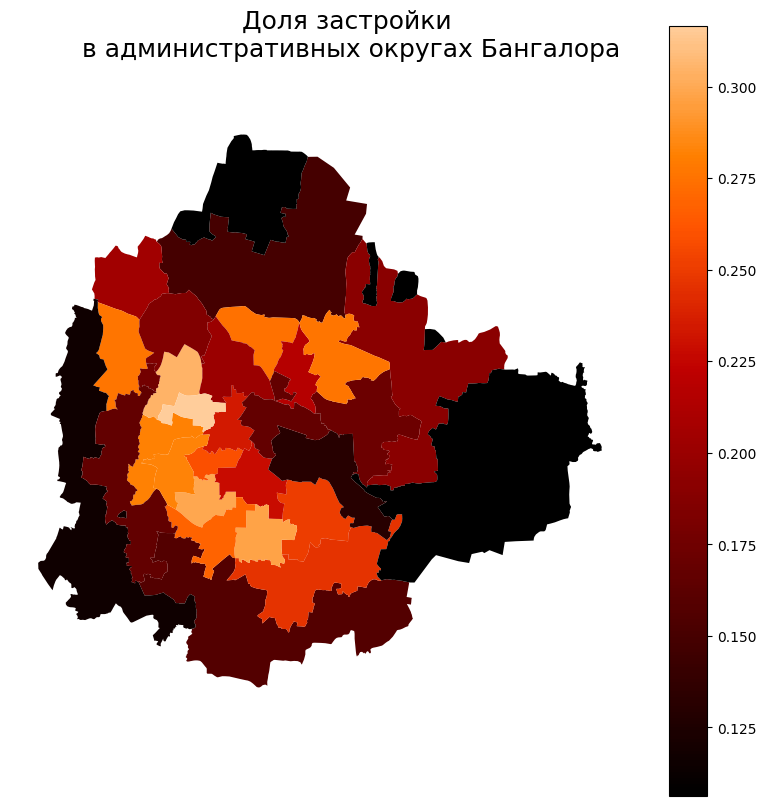

In [200]:
fig, ax = plt.subplots(figsize=(10, 10))
bangalore_divisions_aggregated.plot(
    column='builds/area',
    cmap=trunc,
    legend=True,
    # edgecolor='black',
    # linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)

# bangalore_divisions_aggregated.boundary.plot(ax=ax, edgecolor='black', linewidth=0.1)
ax.set_title('Доля застройки \nв административных округах Бангалора',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_divisions_all_buildings.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

Изображение сохранено: Визуализация/Bengaluru_divisions_slums_15.png


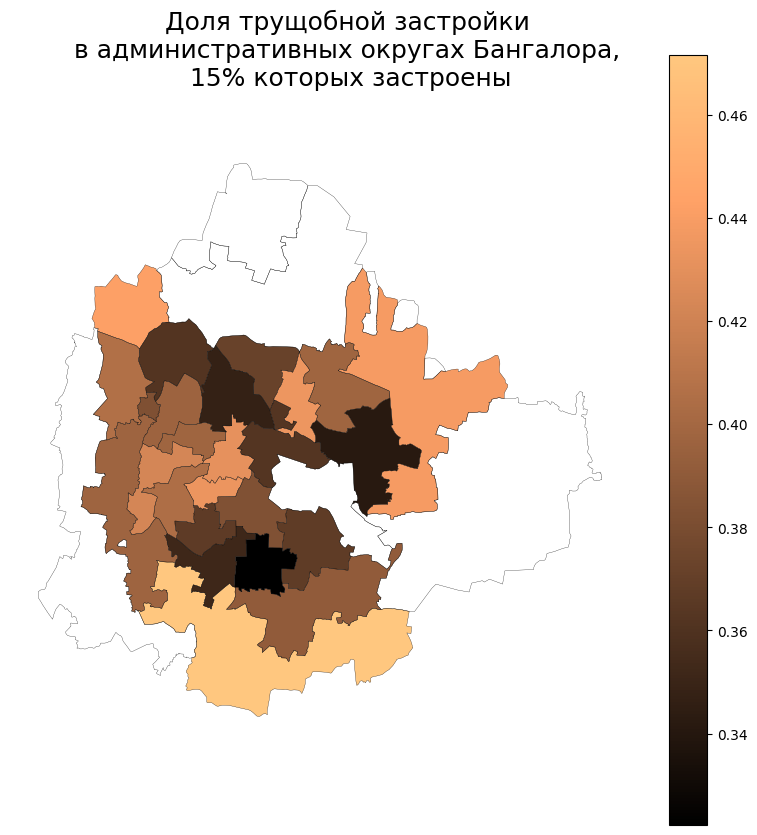

In [206]:
bangalore_divisions_filtered = bangalore_divisions_aggregated[bangalore_divisions_aggregated['builds/area']>0.15]
fig, ax = plt.subplots(figsize=(10, 10))
bangalore_divisions_filtered.plot(
    column='slums/all_builds',
    cmap='copper',
    legend=True,
    # edgecolor='grey',
    # linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
bangalore_divisions_aggregated.boundary.plot(ax=ax, edgecolor='black', linewidth=0.2)
ax.set_title('Доля трущобной застройки \nв административных округах Бангалора, \n15% которых застроены',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_divisions_slums_15.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

### Микрорайоны Бангалора

In [ ]:
# def extract_polygons(geom):
#     if geom.geom_type == 'GeometryCollection':
#         polys = [g for g in geom.geoms if isinstance(g, (Polygon, MultiPolygon))]
#         if not polys:
#             return None
#         return unary_union(polys)
#     return geom

# bangalore_wards = bangalore_wards.copy()
# bangalore_wards['geometry'] = bangalore_wards['geometry'].apply(extract_polygons)
# nd_wards_cleaned = nd_wards_cleaned.dropna(subset=['geometry']).reset_index(drop=True)

# output_path = "Границы/nd_wards_cleaned.geojson"
# nd_wards_cleaned.to_file(output_path)

In [193]:
bangalore_wards = bangalore_wards.to_crs(grid_clipped.crs)
grid_with_bangalore_wards = gpd.sjoin(
    grid_clipped[['builds_area_m2', 'slum_area_m2', 'geometry']],
    bangalore_wards[['Ward Name', 'geometry']],
    how='right',
    predicate='within'
).fillna(0)

sum_agg = (
    grid_with_bangalore_wards
    .groupby('Ward Name')[['builds_area_m2', 'slum_area_m2']]
    .sum()
    .reset_index()
)

bangalore_wards_aggregated = bangalore_wards.merge(
    sum_agg,
    on='Ward Name',
    how='left'
)
bangalore_wards_aggregated['area'] = bangalore_wards_aggregated.geometry.area
bangalore_wards_aggregated['builds/area'] = bangalore_wards_aggregated['builds_area_m2'] / bangalore_wards_aggregated['area']
bangalore_wards_aggregated['slums/area'] = bangalore_wards_aggregated['slum_area_m2'] / bangalore_wards_aggregated['area']
bangalore_wards_aggregated['slums/all_builds'] = bangalore_wards_aggregated['slum_area_m2'] / (bangalore_wards_aggregated['builds_area_m2'] + bangalore_wards_aggregated['slum_area_m2'])
bangalore_wards_aggregated = bangalore_wards_aggregated.fillna(0)

bangalore_wards_aggregated.to_file("bangalore_wards_aggregated.geojson", driver='GeoJSON')
bangalore_wards_aggregated.to_file("bangalore_wards_aggregated.shp")

C:\Users\Mariia\AppData\Local\Temp\ipykernel_12336\2404922238.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bangalore_wards_aggregated.to_file("bangalore_wards_aggregated.shp")
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'styleMapHash' to 'styleMapHa'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'description' to 'descriptio'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke-opacity' to 'stroke-opa'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'stroke-width' to 'stroke-wid'
  ogr_write(
D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: N

Изображение сохранено: Визуализация/Bengaluru_wards_slums.png


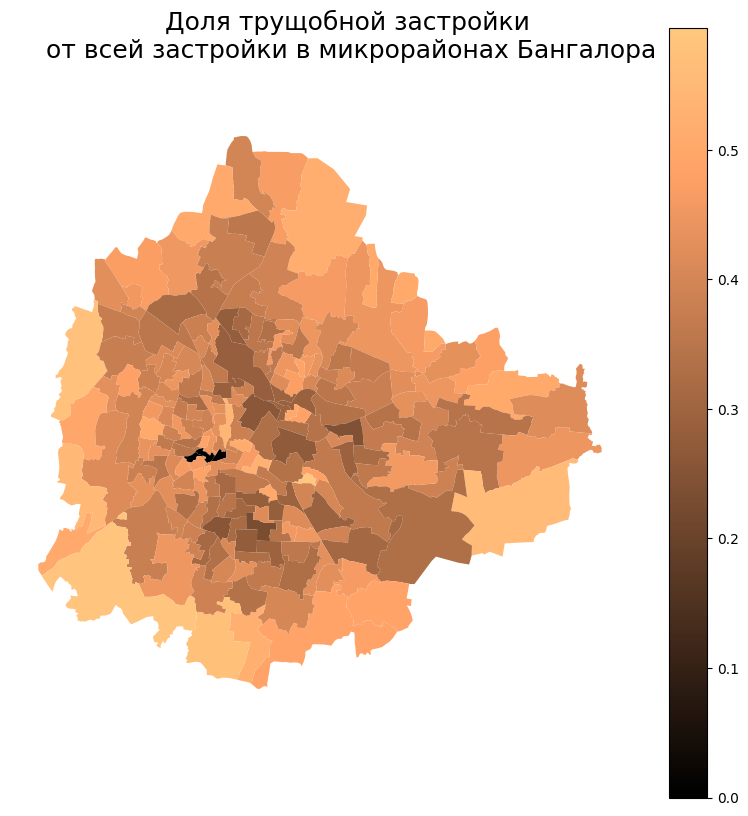

In [204]:
fig, ax = plt.subplots(figsize=(10, 10))
bangalore_wards_aggregated.plot(
    column='slums/all_builds',
    cmap='copper', #gist_yarg'
    legend=True,
    # edgecolor='black',
    # linewidth=0.1,
    ax=ax,
    # missing_kwds={'color': 'lightgrey'}
)
# bangalore_wards_aggregated.boundary.plot(ax=ax, edgecolor='grey', linewidth=0.1)
ax.set_title('Доля трущобной застройки \nот всей застройки в микрорайонах Бангалора',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_wards_slums.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

Изображение сохранено: Визуализация/Bengaluru_wards_all_buildings.png


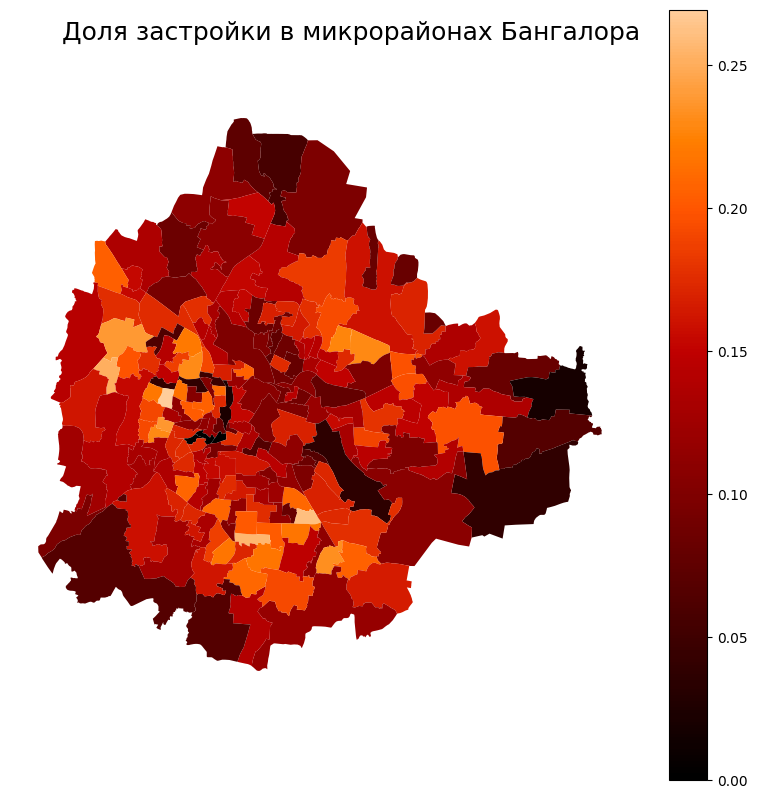

In [207]:
fig, ax = plt.subplots(figsize=(10, 10))
bangalore_wards_aggregated.plot(
    column='builds/area',
    cmap=trunc,
    legend=True,
    # edgecolor='grey',
    # linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)

# bangalore_wards_aggregated.boundary.plot(ax=ax, edgecolor='black', linewidth=0.1)
ax.set_title('Доля застройки в микрорайонах Бангалора',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_wards_all_buildings.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

Изображение сохранено: Визуализация/Bengaluru_wards_slums_20.png


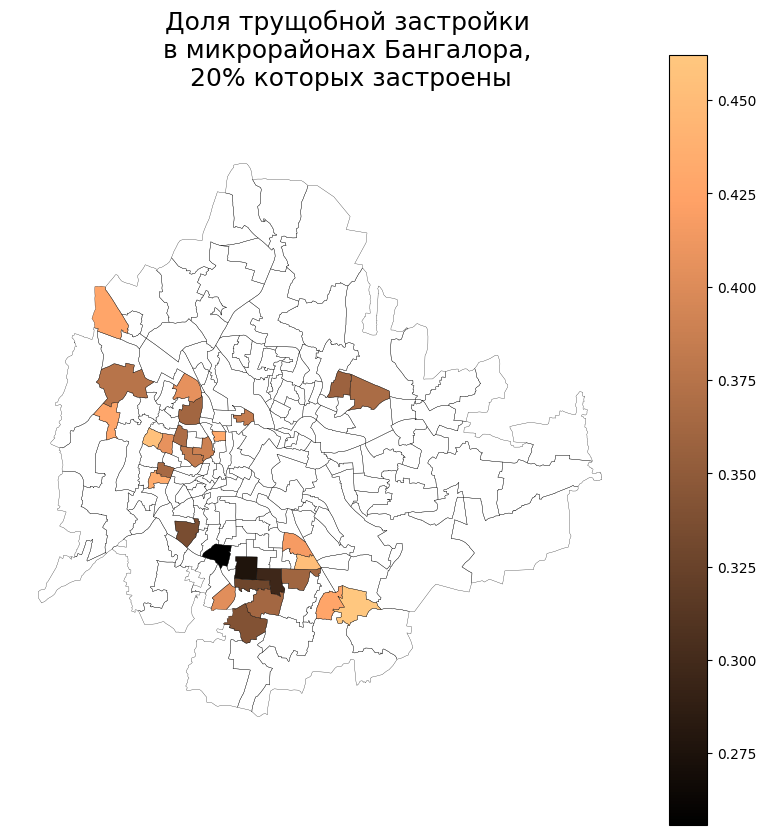

In [208]:
bangalore_wards_filtered = bangalore_wards_aggregated[bangalore_wards_aggregated['builds/area']>0.2]
fig, ax = plt.subplots(figsize=(10, 10))
bangalore_wards_filtered.plot(
    column='slums/all_builds',
    cmap='copper',
    legend=True,
    # edgecolor='grey',
    # linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
bangalore_wards_aggregated.boundary.plot(ax=ax, edgecolor='black', linewidth=0.2)
ax.set_title('Доля трущобной застройки \nв микрорайонах Бангалора, \n20% которых застроены',
             {'fontsize': 18,'horizontalalignment': 'center'},loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Bengaluru_wards_slums_20.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()